Bayesian Final Project

Resources  
- http://varianceexplained.org/statistics/beta_distribution_and_baseball/
- https://docs.google.com/document/d/1bOKHhM5-GTq77LVg3LbN3ih2ZcnQl981UQnA1jWSdF8/edit#



In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns

/opt/anaconda3/lib/python3.7/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
nba = pd.read_csv("bask_clean.csv", dtype={'Abb':'category'})

In [4]:
nba.head()
# Final = total wins out of 82 games 
# Wins = total wins as of Dec 5
# Loss = total losses as of Dec 5
# Games = total games as of Dec 5
# Proj = for the whole year

# how to choose alpha and beta
# how to implement sampling??
# what is a "good" posterior??

,Unnamed: 0,City,Team,Abb,Year,Final,Games,Loss,Proj,Wins
0,0,Atlanta,Hawks,ATL,16-17,43.0,22.0,12.0,43.5,10.0
1,1,Atlanta,Hawks,ATL,17-18,24.0,23.0,18.0,25.5,5.0
2,2,Atlanta,Hawks,ATL,18-19,29.0,25.0,20.0,23.5,5.0
3,3,Atlanta,Hawks,ATL,19-20,NaN,22.0,17.0,32.5,5.0
4,4,Boston,Celtics,BOS,16-17,53.0,21.0,9.0,52.5,12.0


In [5]:
alpha_0 = 1
beta_0  = 1

In [6]:
nba.query('Abb=="ATL"')

,Unnamed: 0,City,Team,Abb,Year,Final,Games,Loss,Proj,Wins
0,0,Atlanta,Hawks,ATL,16-17,43.0,22.0,12.0,43.5,10.0
1,1,Atlanta,Hawks,ATL,17-18,24.0,23.0,18.0,25.5,5.0
2,2,Atlanta,Hawks,ATL,18-19,29.0,25.0,20.0,23.5,5.0
3,3,Atlanta,Hawks,ATL,19-20,NaN,22.0,17.0,32.5,5.0


In [7]:
atl = nba.query('Abb=="ATL"').query('Year!="19-20"')
atl

# a/a+b should equal proj/82

,Unnamed: 0,City,Team,Abb,Year,Final,Games,Loss,Proj,Wins
0,0,Atlanta,Hawks,ATL,16-17,43.0,22.0,12.0,43.5,10.0
1,1,Atlanta,Hawks,ATL,17-18,24.0,23.0,18.0,25.5,5.0
2,2,Atlanta,Hawks,ATL,18-19,29.0,25.0,20.0,23.5,5.0


$Expected = \frac{\alpha}{\alpha + \beta}$

In [8]:
# alpha_star = alpha_0 + sum(games_won)
alpha_star_ATL = alpha_0 + sum(atl.Wins)
alpha_star_ATL

21.0

In [9]:
# beta_star_ATL = games_played - games_won - beta_0
beta_star_ATL = sum(atl.Games) - beta_0
beta_star_ATL

69.0

In [10]:
E_ATL = alpha_star_ATL/(alpha_star_ATL + beta_star_ATL)
E_ATL

0.23333333333333334

Posterior:  $\theta|Y \sim Beta(\alpha + Y, \beta + n - Y)$  
Y = number of wins  
n = number of games played

Text(0.5, 1.0, 'ATL')

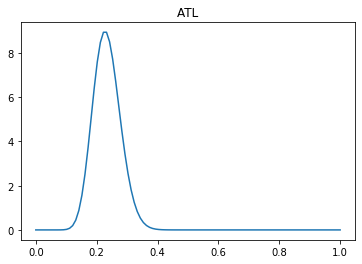

In [11]:
x = np.linspace(0, 1, 100)
y = stats.beta(alpha_star_ATL, beta_star_ATL).pdf(x)
plt.plot(x, y)
plt.title('ATL')

## Therapeutic Touch Example

In [12]:
team_idx = nba.Abb.cat.codes.values
team_codes = nba.Abb.cat.categories
n_teams = team_codes.size

In [13]:
team_codes

Index(['ATL', 'BOS', 'BRK', 'CHI', 'CHO', 'CLE', 'DAL', 'DEN', 'DET', 'GSW',
       'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK',
       'OKC', 'ORL', 'PHI', 'PHO', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS'],
      dtype='object')

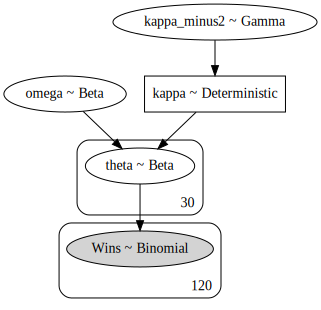

In [14]:
with pm.Model() as hierarchical_model:
    omega = pm.Beta('omega', 1., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=n_teams)
        
    y = pm.Binomial('Wins', n=n_teams, p=theta[team_idx], observed=nba.Wins)    

pm.model_to_graphviz(hierarchical_model)

In [17]:
with hierarchical_model:
    trace = pm.sample(5000, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, kappa_minus2, omega]
Sampling 2 chains: 100%|██████████| 11000/11000 [40:58<00:00,  4.47draws/s] 


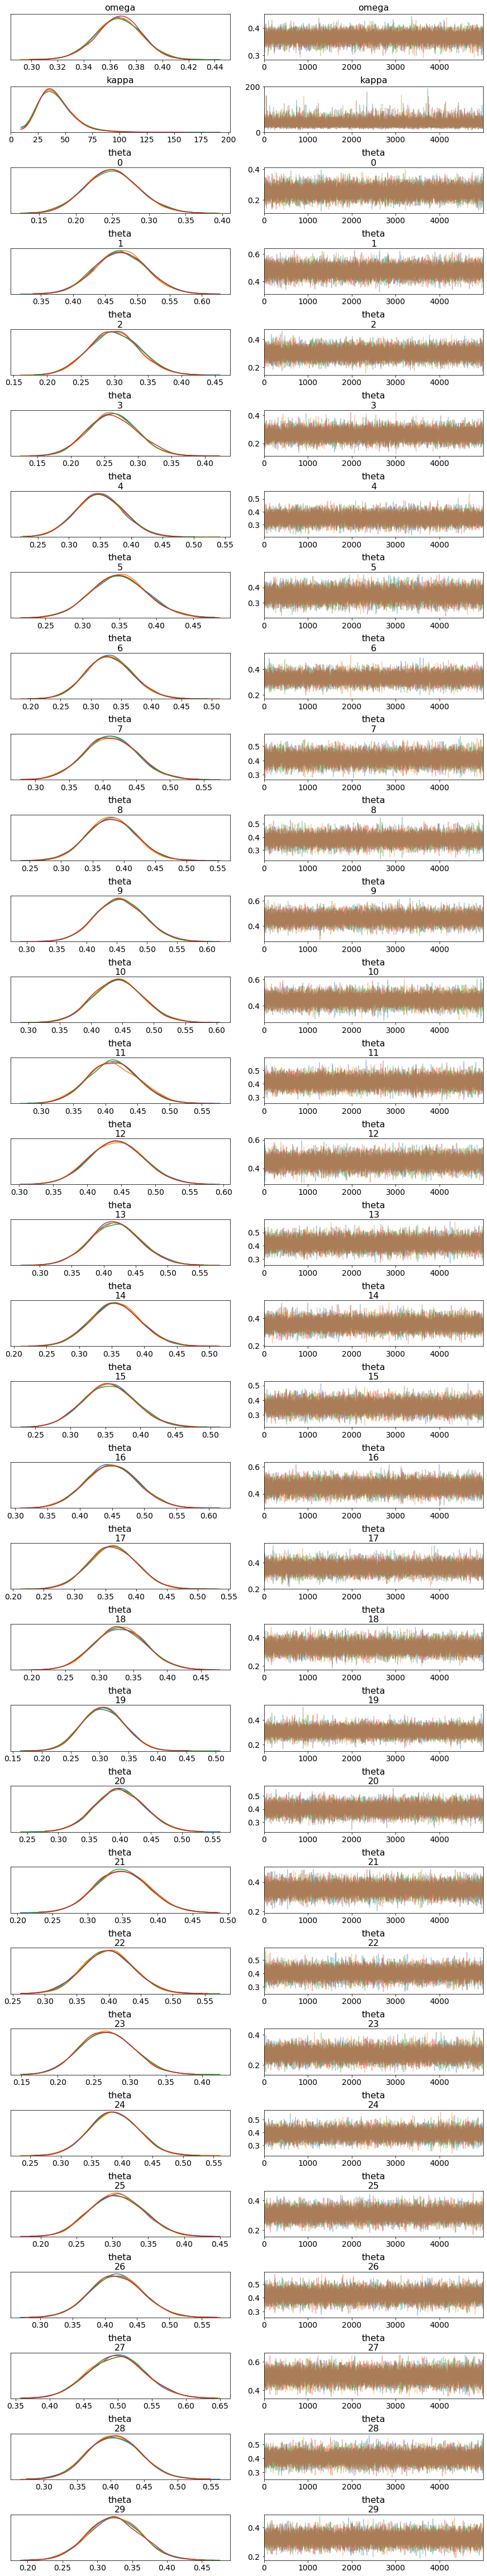

In [29]:
pm.traceplot(trace, ['omega','kappa', 'theta']);

In [ ]:
pm.summary(trace)